# Homework 2024.9.8

## 运行和测试第 1 部分的聊天机器人（ChatBot-Only），并尝试找到一个其无法回答正确的事实性问题。

In [1]:
%%capture --no-stderr
# 安装 LangGraph 和 LangSmith，用于状态图和跟踪
%pip install -U langgraph langsmith

In [2]:
import os

# 开启 LangSmith 跟踪，便于调试和查看详细执行信息
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ChatBot"

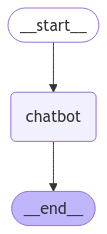

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# 定义状态类型，继承自 TypedDict，并使用 add_messages 函数将消息追加到现有列表
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 创建一个状态图对象，传入状态定义
graph_builder = StateGraph(State)

from langchain_openai import ChatOpenAI

# 初始化一个 GPT-4o-mini 模型
chat_model = ChatOpenAI(model="gpt-4o-mini")

# 定义聊天机器人的节点函数，接收当前状态并返回更新的消息列表
def chatbot(state: State):
    return {"messages": [chat_model.invoke(state["messages"])]}

# 第一个参数是唯一的节点名称，第二个参数是每次节点被调用时的函数或对象
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 编译状态图并生成可执行图对象
graph = graph_builder.compile()

# 你可以使用 get_graph 方法来可视化图，并结合 draw 方法（如 draw_ascii 或 draw_png）
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [4]:
# 开始一个简单的聊天循环
while True:
    # 获取用户输入
    user_input = input("User: ")
    
    # 可以随时通过输入 "quit"、"exit" 或 "q" 退出聊天循环
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")  # 打印告别信息
        break  # 结束循环，退出聊天

    # 将每次用户输入的内容传递给 graph.stream，用于聊天机器人状态处理
    # "messages": ("user", user_input) 表示传递的消息是用户输入的内容
    for event in graph.stream({"messages": ("user", user_input)}):
        
        # 遍历每个事件的值
        for value in event.values():
            # 打印输出 chatbot 生成的最新消息
            print("Assistant:", value["messages"][-1].content)

User:  介绍一下Gradio 5.0的新特性


Assistant: Gradio 5.0 引入了一些重要的新特性和改进，旨在提升用户体验和功能性。以下是一些主要的新特性：

1. **改进的界面设计**：Gradio 5.0 提供了更新和优化的用户界面，支持更丰富的布局和自定义选项，使得创建和分享应用程序更加直观和美观。

2. **新的组件**：新增了一些组件，如更灵活的图像和文本输入选项，使得用户可以更容易地构建复杂的应用程序。

3. **更好的性能**：在性能方面，Gradio 5.0 进行了多项优化，确保应用程序的响应速度更快，用户体验更流畅。

4. **增强的支持**：增强了对不同模型和框架的支持，用户可以更方便地集成他们的机器学习模型。

5. **社区和文档**：Gradio 5.0 提供了更完善的文档和社区支持，帮助用户更快上手并解决问题。

6. **可扩展性**：提供了更好的扩展性，允许开发者自定义和扩展现有组件，以满足特定需求。

以上是 Gradio 5.0 的一些主要新特性，具体的功能和改进可能会随官方文档的更新而有所变化，建议查看 Gradio 的官方网站获取最新信息。


User:  q


Goodbye!


## 使用联网查询工具（如：Tavily），在第 2 部分的聊天机器人（ChatBot + Tool）上测试相同问题，并对比生成结果。

In [5]:
%%capture --no-stderr
# 安装 Tavily 搜索引擎的 Python 包
%pip install -U tavily-python
%pip install -U langchain_community

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults

# 定义 Tavily 搜索工具，最大搜索结果数设置为 2
tool = TavilySearchResults(max_results=2)
tools = [tool]

In [7]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages

# 定义状态
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# 初始化 LLM 并绑定搜索工具
chat_model = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = chat_model.bind_tools(tools)

# 更新聊天机器人节点函数，支持工具调用
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 将更新后的节点添加到状态图中
graph_builder.add_node("chatbot", chatbot)

In [8]:
import json
from langchain_core.messages import ToolMessage

# 定义 BasicToolNode，用于执行工具请求
class BasicToolNode:
    """一个在最后一条 AIMessage 中执行工具请求的节点。
    
    该节点会检查最后一条 AI 消息中的工具调用请求，并依次执行这些工具调用。
    """

    def __init__(self, tools: list) -> None:
        # tools 是一个包含所有可用工具的列表，我们将其转化为字典，
        # 通过工具名称（tool.name）来访问具体的工具
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        """执行工具调用
        
        参数:
        inputs: 包含 "messages" 键的字典，"messages" 是对话消息的列表，
                其中最后一条消息可能包含工具调用的请求。
        
        返回:
        包含工具调用结果的消息列表
        """
        # 获取消息列表中的最后一条消息，判断是否包含工具调用请求
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("输入中未找到消息")

        # 用于保存工具调用的结果
        outputs = []

        # 遍历工具调用请求，执行工具并将结果返回
        for tool_call in message.tool_calls:
            # 根据工具名称找到相应的工具，并调用工具的 invoke 方法执行工具
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # 将工具调用结果作为 ToolMessage 保存下来
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),  # 工具调用的结果以 JSON 格式保存
                    name=tool_call["name"],  # 工具的名称
                    tool_call_id=tool_call["id"],  # 工具调用的唯一标识符
                )
            )
        # 返回包含工具调用结果的消息
        return {"messages": outputs}

In [9]:
# 将 BasicToolNode 添加到状态图中
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [10]:
from typing import Literal

# 定义路由函数，检查工具调用
def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    使用条件边来检查最后一条消息中是否有工具调用。
    
    参数:
    state: 状态字典或消息列表，用于存储当前对话的状态和消息。
    
    返回:
    如果最后一条消息包含工具调用，返回 "tools" 节点，表示需要执行工具调用；
    否则返回 "__end__"，表示直接结束流程。
    """
    # 检查状态是否是列表类型（即消息列表），取最后一条 AI 消息
    if isinstance(state, list):
        ai_message = state[-1]
    # 否则从状态字典中获取 "messages" 键，取最后一条消息
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    # 如果没有找到消息，则抛出异常
    else:
        raise ValueError(f"输入状态中未找到消息: {state}")

    # 检查最后一条消息是否有工具调用请求
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"  # 如果有工具调用请求，返回 "tools" 节点
    return "__end__"  # 否则返回 "__end__"，流程结束

# 添加条件边，判断是否需要调用工具
graph_builder.add_conditional_edges(
    "chatbot",  # 从聊天机器人节点开始
    route_tools,  # 路由函数，决定下一个节点
    {
        "tools": "tools", 
        "__end__": "__end__"
    },  # 定义条件的输出，工具调用走 "tools"，否则走 "__end__"
)

# 当工具调用完成后，返回到聊天机器人节点以继续对话
graph_builder.add_edge("tools", "chatbot")

# 指定从 START 节点开始，进入聊天机器人节点
graph_builder.add_edge(START, "chatbot")

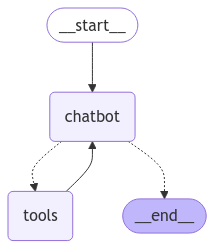

In [11]:
# 编译状态图，生成可执行的流程图
graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [12]:
from langchain_core.messages import BaseMessage

# 进入一个无限循环，用于模拟持续的对话
while True:
    # 获取用户输入
    user_input = input("User: ")
    
    # 如果用户输入 "quit"、"exit" 或 "q"，则退出循环，结束对话
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")  # 打印告别语
        break  # 退出循环

    # 使用 graph.stream 处理用户输入，并生成机器人的回复
    # "messages" 列表中包含用户的输入，传递给对话系统
    for event in graph.stream({"messages": [("user", user_input)]}):
        
        # 遍历 event 的所有值，检查是否是 BaseMessage 类型的消息
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                # 如果消息是 BaseMessage 类型，则打印机器人的回复
                print("Assistant:", value["messages"][-1].content)


User:  介绍一下Gradio 5.0的新特性


Assistant: 
Assistant: [{"url": "https://www.jiqizhixin.com/articles/2024-10-10-6", "content": "\u4ee5\u4e0b\u662f Gradio 5 \u4e2d\u7684 5 \u4e2a\u65b0\u529f\u80fd\uff08\u5305\u62ec\u4e00\u79cd\u65e0\u9700\u7f16\u5199\u4ee3\u7801\u5373\u53ef\u6784\u5efa Gradio \u5e94\u7528\u7684\u65b0\u65b9\u5f0f!. \u9996\u5148\u662f\u52a0\u8f7d\u901f\u5ea6\u3002. \u5982\u679c\u4e4b\u524d\u4f60\u4f7f\u7528\u8fc7 Gradio \uff0c\u7ed9\u4f60\u7684\u7b2c\u4e00\u611f\u89c9\u53ef\u80fd\u5c31\u662f\u52a0\u8f7d\u8fc7\u6162\u3002. \u73b0\u5728 Gradio 5 \u6709\u4e86\u91cd\u5927\u7684\u6027\u80fd\u6539\u8fdb\uff0c\u5305\u62ec\u901a\u8fc7\u670d\u52a1\u5668\u7aef\u6e32\u67d3 (SSR) \u63d0\u4f9b\u5e94\u7528\u7a0b\u5e8f\uff0c\u4ece\u800c\u5b9e\u73b0"}, {"url": "https://huggingface.co/blog/gradio-5", "content": "Gradio 5: production-ready machine learning apps With Gradio 5, developers can build production-ready machine learning web applications that are performant, scalable, beautifully designed, accessible, and follow

User:  q


Goodbye!


## 生成结果对比

下面对比使用 搜索引擎工具前后，chatbot 生成结果对比


### 用户问题

```shell
User:  介绍一下Gradio 5.0的新特性
```

### ChatBot + Web Search Tool（整合搜索结果后生成正确回答）

```
Gradio 5.0 引入了一系列新特性，旨在帮助开发者更轻松地构建生产级的机器学习应用。以下是 Gradio 5.0 的主要新特性：

1. **显著提升的加载速度**：Gradio 5.0 对性能进行了重大改进，特别是应用程序的加载速度得到了提升，使用服务端渲染（SSR）技术进一步优化应用性能。

2. **生产就绪的机器学习应用**：Gradio 5.0 支持开发高性能、可扩展、美观且符合最佳网络安全实践的机器学习应用。开发者只需编写少量 Python 代码即可构建出完整的 web 应用。

3. **用户体验优化**：该版本基于开发者的反馈，解决了以往使用 Gradio 时的常见痛点，提供了一个更稳健的基础，以便开发者可以轻松构建各种机器学习应用。

4. **增强的可访问性**：Gradio 5.0 在设计上更加注重可访问性，使得更多用户能够使用应用。

5. **最佳安全实践**：新版本遵循最佳的网络安全实践，确保应用的安全性。

这些新特性使得 Gradio 5.0 成为一个更强大和灵活的工具，适合开发各种机器学习相关的 web 应用。有关 Gradio 5.0 的更多详细信息，可以查看 [Hugging Face 的官方博客](https://huggingface.co/blog/gradio-5)。
```

### ChatBot-only（模型自己编造的 Gradio 5.0 新特性）

```
Assistant: Gradio 5.0 引入了一些重要的新特性和改进，旨在提升用户体验和功能性。以下是一些主要的新特性：

1. **改进的界面设计**：Gradio 5.0 提供了更新和优化的用户界面，支持更丰富的布局和自定义选项，使得创建和分享应用程序更加直观和美观。

2. **新的组件**：新增了一些组件，如更灵活的图像和文本输入选项，使得用户可以更容易地构建复杂的应用程序。

3. **更好的性能**：在性能方面，Gradio 5.0 进行了多项优化，确保应用程序的响应速度更快，用户体验更流畅。

4. **增强的支持**：增强了对不同模型和框架的支持，用户可以更方便地集成他们的机器学习模型。

5. **社区和文档**：Gradio 5.0 提供了更完善的文档和社区支持，帮助用户更快上手并解决问题。

6. **可扩展性**：提供了更好的扩展性，允许开发者自定义和扩展现有组件，以满足特定需求。

以上是 Gradio 5.0 的一些主要新特性，具体的功能和改进可能会随官方文档的更新而有所变化，建议查看 Gradio 的官方网站获取最新信息。
```